# Preparing a Trial

## Getting started

Before we can actually track the fish, we need to give `cvtracer` some information. You can do this in two steps. 
1. Enter trial-specific information.
2. Initialize a new `Trial` object. This will open a GUI that allows you to identify the tank walls.

Once you have entered this information and identified the walls you have prepared the run for tracking.

## Initialize Trial and identify tank walls

First we need to import some python libraries including the Trial object from cv-tracer.

In [1]:
import sys
import os
from cvt.TrAQ.Trial import Trial

Now that we have loaded the libraries we need, we can start this trial by entering the following information. Make sure you're entering data specific to this trial.

In [2]:
raw_video   = "data/20190208_SF_n20_t1_2325/raw.mp4"
n           =  20
t           = "SF"
date        = "20190208" #YYYYMMDD
fps         =  30
tank_radius =  55.5 #cm
t_start     =   0 #sec
t_end       =  60 #sec

# just a quick little function to generate run-specific filenames
def fname(_fn):
     return ('/').join(raw_video.split('/')[:-1]) + "/" + _fn

You can initialize a trial by running the next block of code. This creates a Trial object that you will be modifying as you add tracks from the run. This will be saved as 'trial.pik'.

1. Upon initializing the `Trial` object, you will be presented a simple Graphical User Interface (GUI). It should show you an image from the video you're going to track. 

2. Using the GUI, you will identify walls by clicking on three points that fall at the very edge of the water. Ideally these will be spaced far away from each other on the edge of the arena. If you make a mistake, just keep clicking until you have three green points that look good (old ones will turn red).

3. Once three good points have been identified, you can press `Space` and a circle traced through the three points should appear. If it looks good, click inside the circle, the box will fill and then you can double-click `Space` to complete the task.

In [5]:
trial = Trial(raw_video, 
              n = n, 
              t = t, 
              date = date,
              fps = fps, 
              tank_radius = tank_radius,
              t_start = t_start, 
              t_end = t_end )

        Directory organized properly.

        Unable to load Trial from /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/trial.pik 

        Generating new Trial object.

        Tank not found /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/tank.pik 
    Locating tank edges... 

       Tank detection complete.

        Tank object saved as /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/tank.pik 


**If you made a mistake and saved the `Tank` incorrectly,** run the following command and before retrying the last step.

In [4]:
fname_tank = fname("tank.pik")
try:
    os.remove(fname_tank)
    print(fname_tank, "removed.")
except FileNotFoundError:
    print("No tank object to remove.")

data/20190208_SF_n20_t1_2325/tank.pik removed.


 ## Save

If you've made it this far, nice job! You initialized a Trial object. Run the final command to save as `trial.pik`.

In [6]:
trial.save()


        Trial object saved as /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/trial.pik 


True

## Reset ##

If you're not sure where you made a mistake and just need to start from the beginning, run the following to delete saved Trial and Tank objects

In [5]:
fname_trial = fname("trial.pik")
try:
    os.remove(fname_trial)
    print(fname_trial, "removed.")
except FileNotFoundError:
    print("No trial object to remove.")
    
fname_tank = fname("tank.pik")
try:
    os.remove(fname_tank)
    print(fname_tank, "removed.")
except FileNotFoundError:
    print("No tank object to remove.")

data/20190208_SF_n20_t1_2325/trial.pik removed.
data/20190208_SF_n20_t1_2325/tank.pik removed.


# Tracking and processing

## Overview

In order to track and process the trial, you will now need to run another set script. This will involve the following steps:
1. Import the relevant libraries from `cv-tracer`
2. Re-open the appropriate `Trial` object.
3. Enter parameters relevant to this run, and initialize a `CVTracer` object using those parameters. 
4. Run the tracking loop.
5. Process the tracks to convert pixels to centimeters and calculate kinematic quantities like velocity, turning velocity, and acceleration.

## Running the tracking code
First we can import `sys` and `numpy` along with two relevant `cvtracer` class modules.

In [7]:
#!/usr/bin/python3
import sys
import numpy as np
from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.CVTracer import CVTracer

Next we will re-open the `Trial` we initialized in the last step and input tracking parameters.

In [8]:
raw_video = fname("raw.mp4")
# open up the Trial
trial       = Trial(raw_video)

        Directory organized properly.

        Trial loaded from /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/trial.pik 


Next set the start and end times for tracking. You should be able to set this to a longer time than your trial to capture the entire thing.

In [9]:
t_start =  0 # enter start time in seconds
t_end   = 60 # enter   end time in seconds

frame_start = int(t_start * fps)
frame_end   = int(t_end   * fps)

Next, enter information tracking parameters. These parameters are used to identify fish in the each image of the video. `cvtracer` uses functions from the the `openCV` library to do the following:
- handle noise by blurring pixels to smooth the image (may want to increase with higher resolution video)
- set block sizes for thresholding
- set the threshold offset required for contour identification (you may want to change these)
- set the minimum and maximum areas of contours (you will need to change these to handle videos at different resolutions)

In [10]:
n_pixel_blur  =  3 # square-root of n-pixels for threshold blurring
block_size    = 15 # contour block size
thresh_offset = 13 # threshold offset for contour-finding

min_area =  20 # minimum area for threhold detection
max_area = 500 # maximum area for threhold detection

online_viewer = True
view_scale = 1  # scale size online viewer

RGB = True # track in color, false does greyscale

Next, you can initialize the `CVTracer` object using the information set above.

In [11]:
cvt         = CVTracer( trial, frame_start = frame_start, frame_end = frame_end, 
                        n_pixel_blur = n_pixel_blur, block_size = block_size, 
                        threshold_offset = int(thresh_offset), 
                        min_area = min_area, max_area = max_area, len_trail = 3, 
                        RGB = RGB, online = online_viewer, view_scale = view_scale, 
                        GPU = False ) 

cvt.print_title()

13
Using Gaussian Adaptive Threshold
Using Inverted Binary Threshold with [0, 100].


	   ###########################################################
	   #                                                         #
	   #      ___ __   __  _____  ___    _     ___  ___  ___     #
	   #     / __\\ \ / / |__ __|| _ \  / \   / __|| __|| _ \    #
	   #    | (__  \ V / -  | |  |   / / ^ \ | (__ | _| |   /    #
	   #     \___|  \_/     |_|  |_|_\/_/ \_\ \___||___||_|_\    #
	   #                                      v2.0, sept 2019    #
	   #                                                         #
	   #                                  press <esc> to exit    #
	   #                                                         #
	   ###########################################################

	                                 adam patch, fau, jupiter 2019
	                              github.com/patchmemory/cv-tracer
 

	       Tracing 20 fish using video, 
	         /home/apatch/Code/cvtracer/dat

## Time to start tracking!

Now that you have initialized the `CVTracer` you should be ready to go! Run the following loop to over each frame of the video. 

In [12]:
cvt.set_frame(frame_start)
for i_frame in range(cvt.frame_start, cvt.frame_end + 1):
    # load next frame into video tracer
    if cvt.get_frame():
        # first remove all information from outside of tank
        cvt.mask_tank()       
        # detect contours in current frame
        cvt.detect_contours()
        # analyze contours for center and long axis
        cvt.analyze_contours()
        # estimate connection between last frame and current frame
        cvt.connect_frames()
        # store results from current frame in the trial object
        cvt.update_trial()
        # write frame with traces to new video file, show if online
        cvt.draw()
        # write frame to video output
        cvt.write_frame()
        # post frame to screen, may accept user input to break loop
        if not cvt.post_frame(): break
        # print time to terminal
        cvt.print_current_frame()
# put things away
cvt.release()
cvt.trial.save()

       Current tracking time: 00:00:59:50 
       Video capture released.

        Trial object saved as /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/trial.pik 


True

**Note:** If you want it to run faster and don't plan to watch, set `online_viewer = False`. If you do this, review the output video `traced.mp4`.

*If you are interested* in learning more knitty-gritty details of computer vision, this is the part where it *might* be interesting to open up `cvt/TrAQ/CVTracer.py` module using the `Spyder` application that came with Anaconda. In the last cell, functions called by `cvt.<function_name>` are defined in `cvt/TrAQ/CVTracer.py` and each definition begins with  `def <function_name>(...)`. Questions are welcome!

## Processing the results

Finally, we will convert the pixel data to centimeters and calculate some kinematic quantities. The `Trial` object knows how to convert to centimeters thanks to the radius we entered when we defined the `Tank`. It can convert frames to time using the frames per second we gave upon defining the `Trial`. With these two conversions, we are able to determine quantites like velocity and acceleration and director turning velocity and acceleration.

In [13]:
# first convert pixels to centimeters
trial.convert_pixels_to_cm()
trial.calculate_kinematics()
trial.save()


       Converting pixels to (x,y) space in (cm,cm).

       /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/trial.pik converted according to tank size and location
       as specified in /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/tank.pik
       Calculating kinematics...

        Trial object saved as /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/trial.pik 

       ... kinematics calculated for Trial and saved in
             /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/trial.pik 

        Trial object saved as /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/trial.pik 


True

## Now a quick analysis

So now we have some data for a single run. Using this data, let's quickly explore the resulting data in terms of distance to the wall, speed, turning, and schooling.

First of all, if you're just returning to this, go ahead and load the Trial again...

In [15]:
raw_video = fname("raw.mp4")
# open up the Trial
trial       = Trial(raw_video)

        Directory organized properly.

        Trial loaded from /home/apatch/Code/cvtracer/data/20190208_SF_n20_t1_2325/trial.pik 


Next, lets evaluate some cuts to clean up any predictably messy data.

In [16]:

# set this to a desired activity cut for cases 
# where fish are stopping, starting as 0 
activity_cut = 0

val_name  = ['dwall', 'speed', 'omega']
val_range = [ [0, 55.5], [activity_cut, 80], [-25, 25] ]
val_bins  = [   10,     10,     10  ]

n_buffer_frames = 2

# evaluate_cuts will determine which frames need to be excluded 
# three reasons for cuts: 
#   1. occlusions (ocut), 
#   2. speed (vcut), 
#   3. turning speed (wcut)
# you can define the ranges of these cuts above.
tag = trial.evaluate_cuts(n_buffer_frames = n_buffer_frames,
                          ocut = 0,
                          vcut = val_range[1],
                          wcut = val_range[2] )



  Generating occlusion cut using min d_nn = 0.00 cm with 2 buffer frames
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 0, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 1, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 2, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 3, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 4, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 5, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 6, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 7, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 8, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 9, 
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (1785, 2)
    ... for fish 10, 
 Shape before cuts:  (

<Figure size 432x288 with 0 Axes>

Now that the `Trial` knows which frames should be cut, we can calculate and plot statistics of the relevant quantities for individual fish. 

`calculate_statistics` will output plots to the trial's directory.

In [17]:
trial.calculate_statistics(val_name = val_name, 
                           val_range = val_range, 
                           val_bins = val_bins,
                           ocut = True, vcut = True, wcut = True,
                           tag = tag)

   apply_cuts  (642,) 6
   apply_cuts  (605,) 6
   apply_cuts  (606,) 6
   apply_cuts  (675,) 6
   apply_cuts  (602,) 6
   apply_cuts  (672,) 6
   apply_cuts  (572,) 6
   apply_cuts  (604,) 6
   apply_cuts  (779,) 6
   apply_cuts  (771,) 6
   apply_cuts  (510,) 6
   apply_cuts  (790,) 6
   apply_cuts  (597,) 6
   apply_cuts  (601,) 6
   apply_cuts  (531,) 6
   apply_cuts  (604,) 6
   apply_cuts  (716,) 6
   apply_cuts  (532,) 6
   apply_cuts  (517,) 6
   apply_cuts  (566,) 6
 mean and err 16.476426953085635 0.5631565208334188
 mean and err 8.677286260324143 0.4007294778987349
 mean and err 4.015441129643183 0.33685543820095454
   apply_cuts  (642,) 6
   apply_cuts  (605,) 6
   apply_cuts  (606,) 6
   apply_cuts  (675,) 6
   apply_cuts  (602,) 6
   apply_cuts  (672,) 6
   apply_cuts  (572,) 6
   apply_cuts  (604,) 6
   apply_cuts  (779,) 6
   apply_cuts  (771,) 6
   apply_cuts  (510,) 6
   apply_cuts  (790,) 6
   apply_cuts  (597,) 6
   apply_cuts  (601,) 6
   apply_cuts  (531,) 6
   ap

<Figure size 432x288 with 0 Axes>

Now, while it was hidden from you, we already calculated the pairwise distances and alignments of all the fish when we evaluated the cuts. The group object has saved that information. Since this level of analysis might be interesting, let's access that data directly.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

trial.group.collect_distance_alignment(ocut = True, 
                                       vcut = True, 
                                       wcut = True)
dist_align = np.copy(trial.group.dij_mij)

# convert to degrees
dist_align[:,1] = 180/np.pi*np.arccos(dist_align[:,1])

 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (642, 2)
 Shape before cuts:  (1785, 2)
 Shape af

 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (779, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (779, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (779, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (779, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (779, 2)
 Shape befo

 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (604, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (716, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (716, 2)
 Shape before cuts:  (1785, 2)
 Shape after cuts:  (716, 2)
 Shape befo

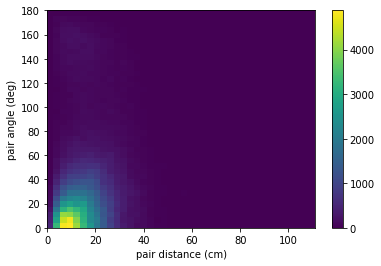

<Figure size 432x288 with 0 Axes>

In [48]:
def plot_pair_map(dist_align, save = False):
    plt.hist2d(dist_align[:,0], dist_align[:,1], 
               bins = [40,40], range=[[0,111],[0,180]])
    plt.xlabel("pair distance (cm)")
    plt.ylabel("pair angle (deg)")
    plt.colorbar()
    if save:
        plt.savefig(fname("pairs_%s.png" % tag))
    else:
        plt.show()
    plt.clf()

plot_pair_map(dist_align)
plot_pair_map(dist_align, save=True)